In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Unpickle all dataset batches to retrieve trainig data, training labels, testing data, and testing labels.
def load_cifar():
    folder_name = "cifar_10_batches/"
    train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
    test_batch = 'test_batch'
    names = 'batches.meta'
    train_data = []
    train_labels = []
    for batch in train_batches:
        data_dict = unpickle(folder_name + batch)
        train_data.append(data_dict[b'data'])
        train_labels += data_dict[b'labels']
    test_dict = unpickle(folder_name + test_batch)
    test_data = test_dict[b'data']
    test_labels = test_dict[b'labels']
    names_dict = unpickle(folder_name + names)
    return np.concatenate(train_data), np.array(train_labels), test_data, np.array(test_labels), names_dict[b'label_names']


'''
- Divide pixel values by 255 to get pixel values to range between [0, 1]
- Original CIFAR data is stored as flattened array in which each row represents an image, so
  reshaping turns each image into (32x32x3), 3 represents rgb.
- Transpose rearranges the structure of the matrix by making the channel dimension data to come last
  aka height x width x channels
'''
def preprocess_data(train_data, test_data):
    train_data = train_data.reshape(-1, 3, 32*32).transpose(0, 2, 1) / 255.0
    test_data = test_data.reshape(-1, 3, 32*32).transpose(0, 2, 1) / 255.0
    return train_data, test_data

def write_data_to_text(train_data, train_labels, test_data, test_labels, train_file, test_file):
    # Write training data and labels to text file
    with open(train_file, 'w') as f:
        f.write("Training Data:\n")
        for data in train_data:
            f.write(','.join(map(str, data)) + '\n')
        f.write("\nTraining Labels:\n")
        f.write(','.join(map(str, train_labels)) + '\n')

    # Write testing data and labels to text file
    with open(test_file, 'w') as f:
        f.write("Testing Data:\n")
        for data in test_data:
            f.write(','.join(map(str, data)) + '\n')
        f.write("\nTesting Labels:\n")
        f.write(','.join(map(str, test_labels)) + '\n')

def np_arrayify(*args):
    the_list = []
    for item in args:
        the_list.append(np.array(item))
    return the_list


### Loading the CIFAR data
We will have the following data loaded in the original format as np arrays:
1. Training data: train_data
2. Training labels: train_labels
3. Test data: test_data
4. Test labels: test_labels
5. Label names: label_names (Note: The strings are represented by bytes)

Additionally, we have created two arrays specifically for easier navigation and visualization of the features
1. 3D-formatted training data + normalization: train_data_visual
2. 3D-formatted testing data + normalization: test_data_visual

In [18]:

train_data, train_labels, test_data, test_labels, label_names = load_cifar()
train_data_visual, test_data_visual = preprocess_data(train_data, test_data)
print(label_names)


[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


### Visualizing the CIFAR data
1. Using the groupings list, which is a categorized version (by class label) of the training visual data, we can take a look at the color trends of the images. This method takes the most saturated color between R,G,B for every 3rd pixel (for runtime speed) and tallies the total count for each color, in order to find the most prevalent colors in each image. In addition, it has a threshold/filter which attempts to remove greyscale pixels (black-grey-white) that don't contribute much information. One drawback of this method is that it doesn't take into account basic color combinations. While it would theoretically be simple to implement, we decide to omit that functionality due to running time issues.

In [5]:
# groupings is a numpy list of lists, where each list is a collection of training datapoints for a specific class
groupings = []
for label in range(len(label_names)):
    groupings.append(train_data_visual[train_labels == label])
groupings = np.array(groupings)

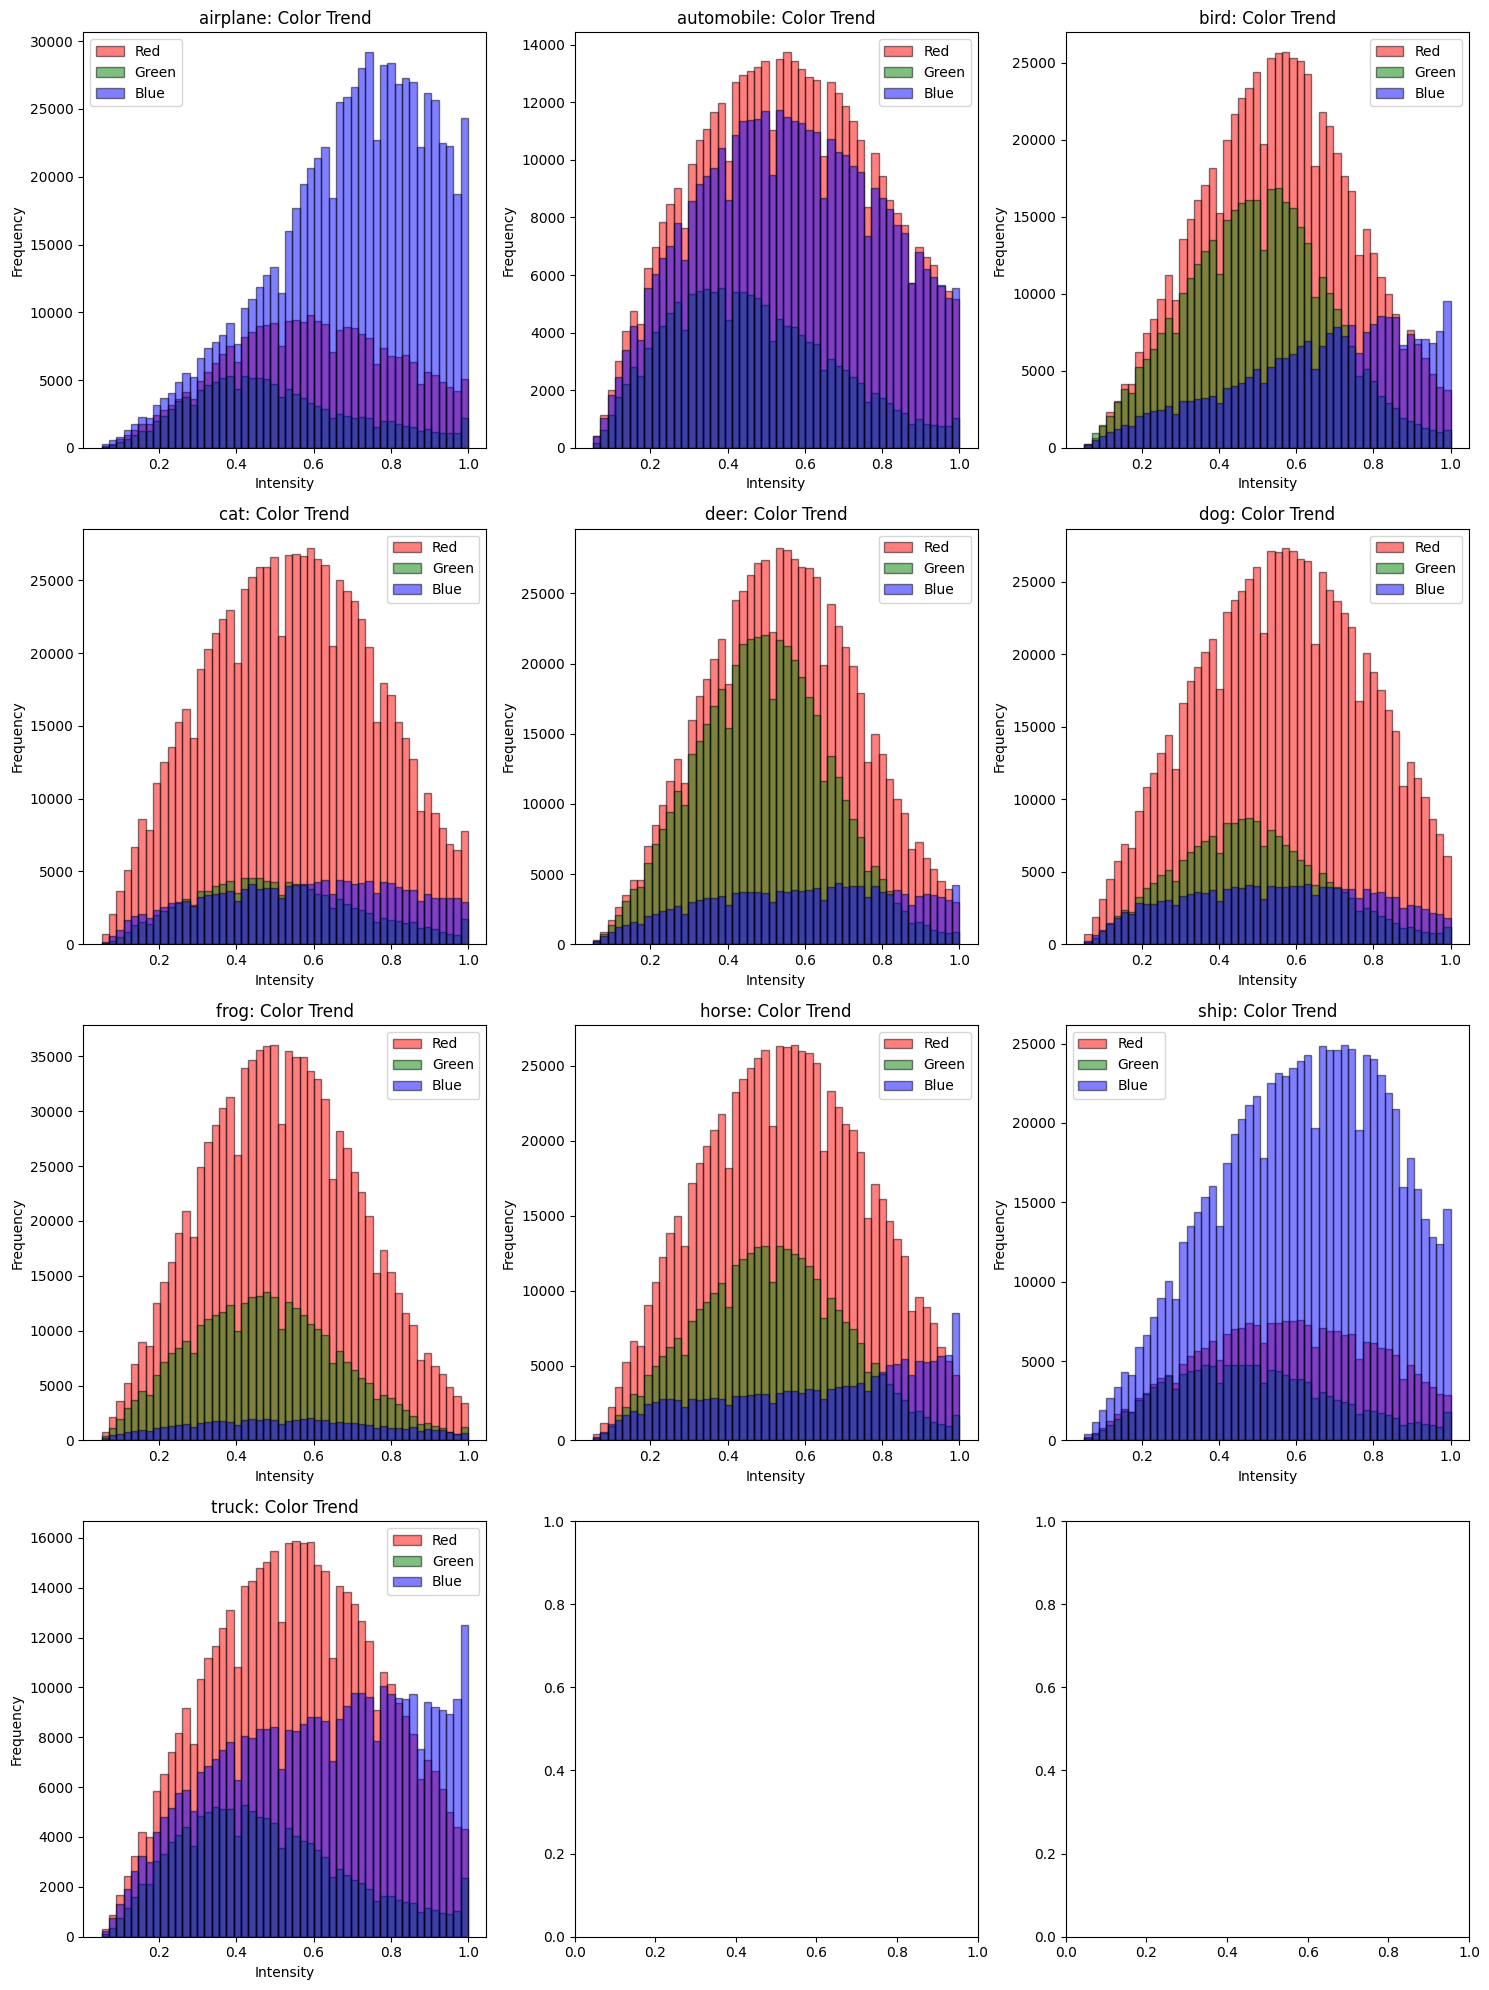

In [6]:
greyscale_threshold = 0.05
num_labels = len(label_names)
num_cols = 3  # Number of columns in the grid
num_rows = (num_labels + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i in range(num_labels):
    row = i // num_cols
    col = i % num_cols
    plot_colors = [[], [], []]
    for datapoint in groupings[i]:
        for pixel in datapoint[::3]:
            max_index = 0
            min_index = 0
            for color in range(1, 3):
                if pixel[color] > pixel[max_index]:
                    max_index = color
                if pixel[color] < pixel[min_index]:
                    min_index = color
            if pixel[max_index] - pixel[min_index] >= greyscale_threshold:
                plot_colors[max_index].append(pixel[max_index])
    axes[row, col].hist(plot_colors[0], bins=50, edgecolor='k', color='red', alpha=0.5, label='Red')
    axes[row, col].hist(plot_colors[1], bins=50, edgecolor='k', color='green', alpha=0.5, label='Green')
    axes[row, col].hist(plot_colors[2], bins=50, edgecolor='k', color='blue', alpha=0.5, label='Blue')
    axes[row, col].set_title(str(label_names[i])[2:-1] + ": Color Trend")
    axes[row, col].set_xlabel('Intensity')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

### Training kNN

First, we will train the kNN classifier on the CIFAR dataset.

Parameters we will experiment with:

1. Value of k --> Number of closest neighbors

Test different k neighbor values ranging from 1, 5, 10, 20.

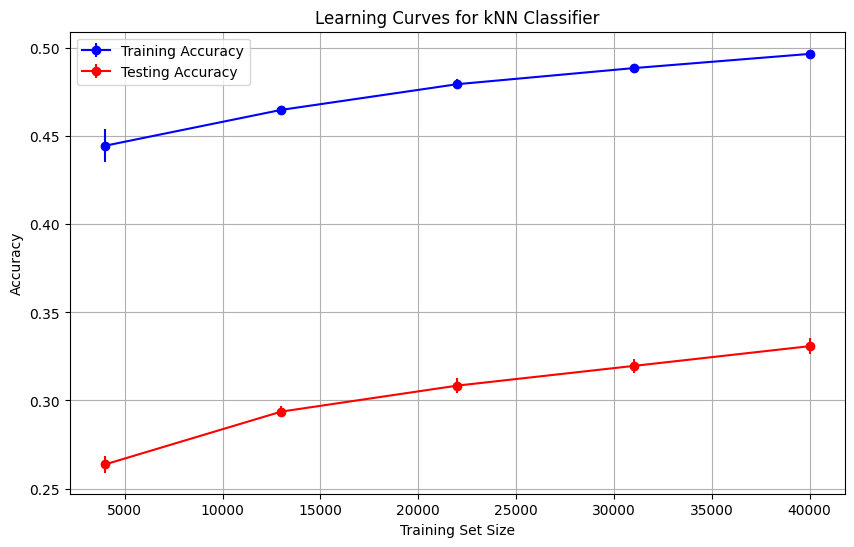

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming you have your dataset and labels stored in train_data, train_labels, test_data, test_labels, and label_names

# Define the range of training set sizes you want to explore
train_sizes = [4000, 13000, 22000, 31000, 40000]  # Example: Varying training set sizes

# Define the number of repetitions for averaging over multiple subsets
num_repeats = 3

train_scores = np.zeros((len(train_sizes), num_repeats))
test_scores = np.zeros((len(train_sizes), num_repeats))

for i, size in enumerate(train_sizes):
    for j in range(num_repeats):
        # Randomly subsample the dataset
        X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, train_size=size, random_state=j)

        # Initialize kNN classifier
        knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

        # Train the classifier
        knn.fit(X_train, y_train)

        # Evaluate the classifier on training and testing sets
        train_scores[i, j] = accuracy_score(y_train, knn.predict(X_train))
        test_scores[i, j] = accuracy_score(y_test, knn.predict(X_test))

# Compute mean and standard deviation of scores over repetitions
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.errorbar(train_sizes, train_scores_mean, yerr=train_scores_std, label='Training Accuracy', fmt='-o', color='b')
plt.errorbar(train_sizes, test_scores_mean, yerr=test_scores_std, label='Testing Accuracy', fmt='-o', color='r')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves for kNN Classifier')
plt.legend()
plt.grid()
plt.show()


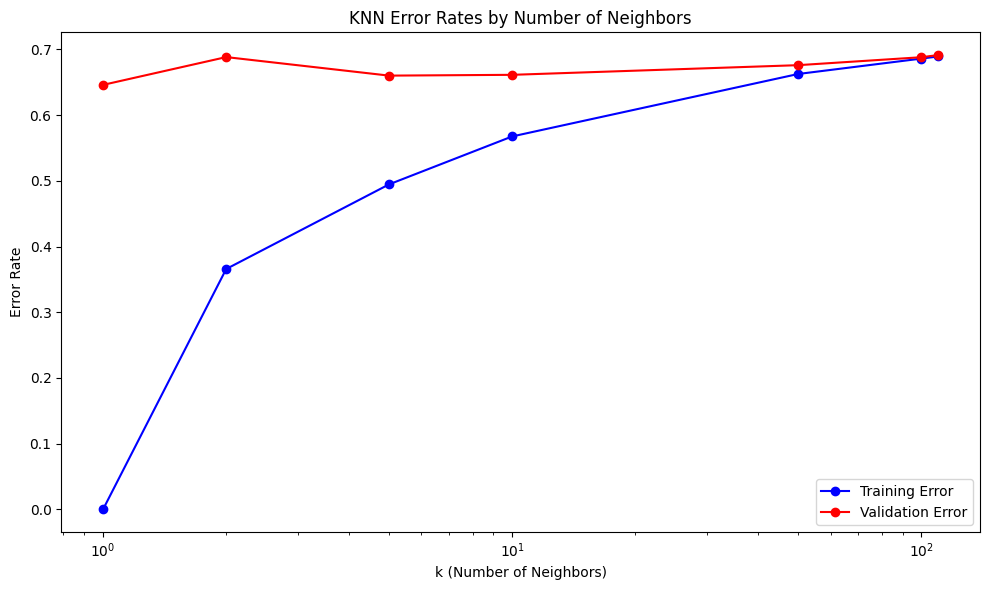

Determined optimal k value for lowest validation error: 1


In [21]:
# Flatten images
train_data_flat = train_data_visual.reshape(train_data_visual.shape[0], -1)
test_data_flat = test_data_visual.reshape(test_data_visual.shape[0], -1)

# Define the range of k values you want to explore
k_values = [1, 2, 5, 10, 50, 100, 110]

errors_training = []
errors_validation = []

for k in k_values:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(train_data_flat, train_labels)

    # Predict outcomes for training and testing datasets
    predictions_training = model_knn.predict(train_data_flat)
    predictions_validation = model_knn.predict(test_data_flat)

    # Calculate error rates for training and validation sets
    error_training = 1 - accuracy_score(train_labels, predictions_training)
    error_validation = 1 - accuracy_score(test_labels, predictions_validation)

    errors_training.append(error_training)
    errors_validation.append(error_validation)

# Plotting
fig, axes = plt.subplots(1, figsize=(10, 6))

axes.semilogx(k_values, errors_training, marker='o', color='blue', label='Training Error')
axes.semilogx(k_values, errors_validation, marker='o', color='red', label='Validation Error')

axes.set_xlabel('k (Number of Neighbors)')
axes.set_ylabel('Error Rate')
axes.set_title('KNN Error Rates by Number of Neighbors')
axes.legend(loc='best')

plt.tight_layout()
plt.show()

optimal_k_value = k_values[np.argmin(errors_validation)]
print(f"Determined optimal k value for lowest validation error: {optimal_k_value}")


### Training Logistic

Next, we will train the logistic classifier on the CIFAR dataset.

Parameters we will experiment with:

1. Regularization type (L1, L2)
2. Regularization strength

Let's begin by determining a good set of parameters for this model on the CIFAR-10 dataset. We will use random search (in contrast to Grid Search) for hyperparameters.

Note: Due to long running times and incompatibility of Logistic Classification on image datasets (failure to converge), I have reduced the training set size, and added SGD to the model to allow the training to proceed in a timely manner.

In [22]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split

parametersToTry = dict(penalty=['l1','l2'], alpha=uniform(0,4))
num_samples = 8 # How many models do we want to train with different parameters?
'''logisC = LogisticRegression()

search = RandomizedSearchCV(logisC, parametersToTry, n_iter=1)

search.fit(train_data, train_labels)
'''

log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(train_data, train_labels, train_size=1000)

logisC = SGDClassifier(loss='log_loss')
search = RandomizedSearchCV(logisC, parametersToTry, n_iter=num_samples)

search.fit(log_X_train, log_y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

RandomizedSearchCV(estimator=SGDClassifier(loss='log_loss'), n_iter=8,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1777d6fb0>,
                                        'penalty': ['l1', 'l2']})

Plotting the results of randomized search

{'alpha': 2.4695381825870157, 'penalty': 'l2'}

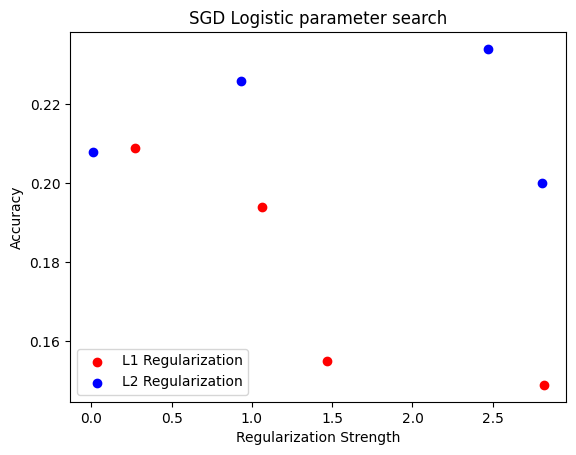

In [10]:
param_choices = search.cv_results_['params']
param_scores = search.cv_results_['mean_test_score']

fig, axes = plt.subplots()
axes.set_xlabel('Regularization Strength')
axes.set_ylabel('Accuracy')
axes.set_title('SGD Logistic parameter search')

reg1 = []
score1 = []
reg2 = []
score2 = []

for i in range(len(param_choices)):
  if param_choices[i]['penalty'] == 'l1':
    reg1.append(param_choices[i]['alpha'])
    score1.append(param_scores[i])
  else:
    reg2.append(param_choices[i]['alpha'])
    score2.append(param_scores[i])


axes.scatter(reg1, score1, color='red', label='L1 Regularization')
axes.scatter(reg2, score2, color='blue', label='L2 Regularization')
axes.legend()

search.best_params_

Now we will use the best parameter settings (obtained by the previous code block) and train the SGD logistic classifier on varying amounts of training data.

In [23]:
best_reg = search.best_params_['alpha']
best_reg_type = search.best_params_['penalty']

# Reusing train_sizes from kNN classifier section
train_sizes = [4000, 13000, 22000, 31000, 40000]

log_train_score = []
log_test_score = []
'''
for trainSize in train_sizes:
  log_X_train2, log_X_test2, log_y_train2, log_y_test2 = train_test_split(train_data, train_labels, train_size=trainSize)

  realLogisC = SGDClassifier(penalty=best_reg_type, alpha=best_reg, loss='log_loss')

  realLogisC.fit(log_X_train2, log_y_train2)

  # Evaluate the classifier on training and testing sets
  log_train_score.append(realLogisC.score(log_X_train2, log_y_train2))
  log_test_score.append(realLogisC.score(log_X_test2, log_y_test2))
'''
for trainSize in train_sizes:
  realLogisC = SGDClassifier(penalty=best_reg_type, alpha=best_reg, loss='log_loss')

  realLogisC.fit(train_data[:trainSize], train_labels[:trainSize])

  # Evaluate the classifier on training and testing sets
  log_train_score.append(realLogisC.score(train_data[:trainSize], train_labels[:trainSize]))
  log_test_score.append(realLogisC.score(test_data, test_labels))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

Plotting the results of training size variation

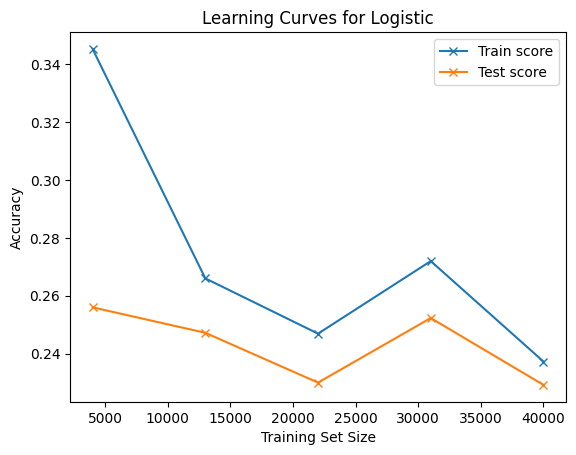

In [24]:
fig, axes = plt.subplots()

axes.plot(train_sizes, log_train_score, '-x', label='Train score')
axes.plot(train_sizes, log_test_score, '-x', label='Test score')

axes.set_xlabel('Training Set Size')
axes.set_ylabel('Accuracy')
axes.set_title('Learning Curves for Logistic')
plt.legend()

Reflection: This is certainly an unusual graph, but it makes sense. The logistic classifier can only create a linear boundary. As our image dataset is so multi-dimensional and complex, the boundary is never able to converge, regardless of the training set size.

For this reason, the model is only able to barely get a fraction correct with a medium training set size - With a small sample size, there is not enough data to be learned, and with a large sample size, there is too much data and variation for the model to fit correctly. I believe this is the reason why the accuracy tends to decrease as the dataset size increases.

In conclusion, logistic classification is not the best model when it comes to complex problems (i.e. lots of features), as the boundary it can create is too simple to completely capture all the nuances in the data.

### Training MLP

For our third classifier, we will train a MLP (Feedforward NN).

Parameters we will experiment with:

1. Hidden Units: The optimal number of hidden units in an MLP is a balance between complexity and general understanding, where too many can lead to overfitting and computational inefficiency, and too few may cause underfitting; thus, it is often determined empirically through validation techniques.
2. Hidden Layer Sizes: In the MLPClassifier, the hidden_layer_sizes=(512,) parameter specifies the number of neurons in the single hidden layer of the network.
3. Max Iterations (max_iter): This parameter specifies the maximum number of epochs, which are iterations over the entire dataset, that the solver iterates.
4. Early Stopping (early_stopping): When set to True, this parameter will stop training as soon as the validation score does not improve, preventing overfitting.
5. Validation Fraction (validation_fraction): This parameter indicates the proportion of training data to set aside as validation set for early stopping. Here, it's set to 0.1, meaning 10% of the training data is used for validation.



[learning_curve] Training set sizes: [ 4000 13000 22000 31000 40000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Iteration 1, loss = 31.27097904
Validation score: 0.132500
Iteration 1, loss = 31.22047922
Validation score: 0.145000
Iteration 2, loss = 27.99958749
Validation score: 0.152500
Iteration 2, loss = 29.28939662
Validation score: 0.150000
Iteration 3, loss = 19.37822783
Validation score: 0.177500
Iteration 3, loss = 25.20334576
Validation score: 0.175000
Iteration 1, loss = 27.55403924
Iteration 1, loss = 26.63090043
Validation score: 0.184615
Validation score: 0.198462
Iteration 4, loss = 10.54813099
Validation score: 0.172500
Iteration 4, loss = 20.63676260
Validation score: 0.185000
Iteration 5, loss = 3.35804440
Iteration 5, loss = 16.08218467
Validation score: 0.095000
Validation score: 0.207500
Iteration 6, loss = 13.74530562
Iteration 6, loss = 2.31427582
Validation score: 0.182500
Validation score: 0.092500
Iteration 1, loss = 23.81460626
Validation score: 0.215000
Iteration 1, loss = 22.12652877
Validation score: 0.207273
Iteration 2, loss = 17.19511741
Iteration 7, loss = 13.598

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.8min finished


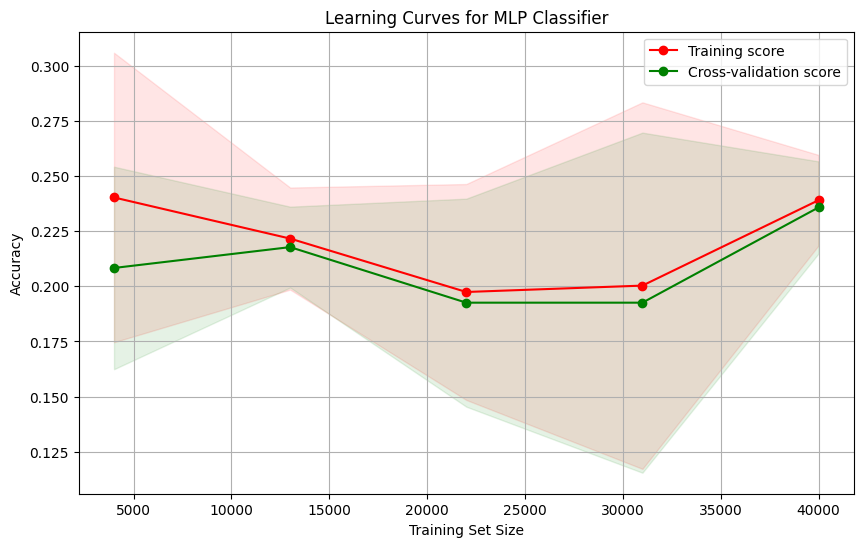

In [13]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

train_data_flat = train_data.reshape(train_data.shape[0], -1)

mlp = MLPClassifier(hidden_layer_sizes=(512,), max_iter=100, verbose=True, early_stopping=True, validation_fraction=0.1)

train_sizes = np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(
    mlp, train_data_flat, train_labels, train_sizes=train_sizes, cv=5,
    scoring='accuracy', n_jobs=-1, verbose=1, shuffle=True, random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves for MLP Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid()
plt.show()


Iteration 1, loss = 2.09090081
Validation score: 0.357200
Iteration 2, loss = 1.77835118
Validation score: 0.386200
Iteration 3, loss = 1.70885796
Validation score: 0.384400
Iteration 4, loss = 1.63924417
Validation score: 0.427400
Iteration 5, loss = 1.58992076
Validation score: 0.422600
Iteration 6, loss = 1.55300447
Validation score: 0.436600
Iteration 7, loss = 1.53308022
Validation score: 0.444400
Iteration 8, loss = 1.50645438
Validation score: 0.438000
Iteration 9, loss = 1.49010258
Validation score: 0.447000
Iteration 10, loss = 1.46493164
Validation score: 0.448600
Iteration 11, loss = 1.45130085
Validation score: 0.454000
Iteration 12, loss = 1.43528369
Validation score: 0.471000
Iteration 13, loss = 1.42107343
Validation score: 0.469800
Iteration 14, loss = 1.39906741
Validation score: 0.477400
Iteration 15, loss = 1.39525787
Validation score: 0.472200
Iteration 16, loss = 1.38072490
Validation score: 0.476400
Iteration 17, loss = 1.37159957
Validation score: 0.460200
Iterat

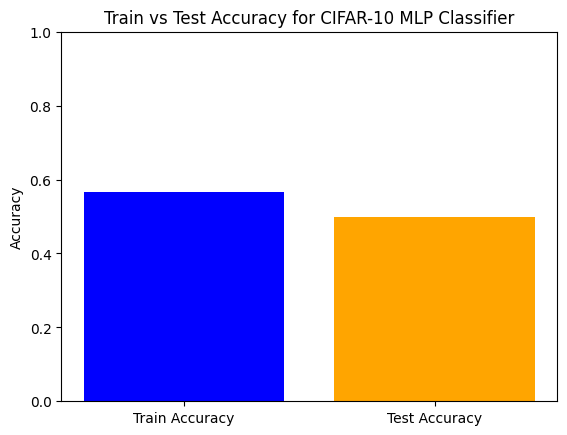

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

train_data, train_labels, test_data, test_labels, label_names = load_cifar()
train_data, test_data = preprocess_data(train_data, test_data)

train_data_flat = train_data.reshape(train_data.shape[0], -1)
test_data_flat = test_data.reshape(test_data.shape[0], -1)

mlp = MLPClassifier(hidden_layer_sizes=(512,), max_iter=100, verbose=True, early_stopping=True, validation_fraction=0.1)
mlp.fit(train_data_flat, train_labels)

train_predictions = mlp.predict(train_data_flat)
test_predictions = mlp.predict(test_data_flat)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

fig, ax = plt.subplots()
ax.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
ax.set_title('Train vs Test Accuracy for CIFAR-10 MLP Classifier')
plt.show()

### Training Random Forest
For our fourth classifier, we will train with Random Forest.

Parameters we will expirement with:

  1.

[learning_curve] Training set sizes: [ 4000 13000 22000 31000 40000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.5min finished


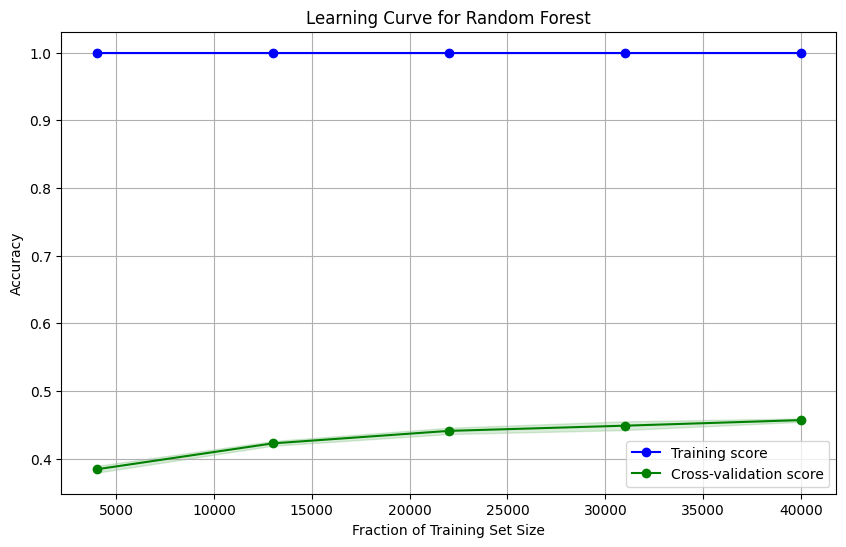

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt


rf = RandomForestClassifier(n_estimators=100, random_state=42)

train_sizes = np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf,
    X=train_data_flat,
    y=train_labels,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.15)
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='green', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='green', alpha=0.15)

plt.title('Learning Curve for Random Forest')
plt.xlabel('Fraction of Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
